# Exploratory Data Analysis
In this notebook, we use the functions we've written in various notebooks to explore how our models' analysis on news sentiment actually compares with changes in stock prices.

In [72]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
import compare_sentiment as comp_sent
import pandas as pd
import matplotlib.pyplot as plt

## Google

In [36]:
#Get Data
google = comp_sent.collapse_articles(data_source = "./data/google-data.pkl", stockName = "GOOG", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
apple = comp_sent.collapse_articles(data_source = "./data/apple-data.pkl", stockName = "AAPL", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
tesla = comp_sent.collapse_articles(data_source = "./data/tesla-data.pkl", stockName = "TSLA", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
micro = comp_sent.collapse_articles(data_source = "./data/Microsoft-data.pkl", stockName = "MSFT", 
                      time_before = '2018-09-27', time_after = '2019-05-17')
amazon = comp_sent.collapse_articles(data_source = "./data/amazon-data.pkl", stockName = "MSFT", 
                      time_before = '2018-09-27', time_after = '2019-05-17')

In [37]:
all_company = pd.concat([google, apple, tesla, micro, amazon])

In [38]:
all_company['liststring'] = all_company['liststring'].apply(lambda x : x.replace("," , " "))

In [39]:
all_company['increase'] = (all_company['delta'] >= 0).astype("int")

In [40]:
all_company.head()

,liststring,delta,increase
time,,,
2018-09-27,MANCHESTER England It was past midnight when J...,5.14,1
2018-09-28,You may have noticed a bold advertisement in T...,8.02,1
2018-10-01,A new sitcom airs on CBS while a new documenta...,-8.93,0
2018-10-02,Student Athlete a documentary with LeBron Jame...,14.04,1
2018-10-03,Apple opened a routine product launch event la...,-9.67,0


In [53]:
#Train test split
X_train, X_test, y_train, y_test = train_test_split(all_company['liststring'], all_company['increase'], test_size=0.20, random_state=42)

# Word Embedding Model

In [55]:
#Tokenize the words
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_company['liststring'])

# max_length = max([len(s.split()) for s in all_company['liststring']])
max_length = 5000
print(max_length)

5000


In [56]:
vocab_size = len(tokenizer.word_index) + 1

X_train_tokens =  tokenizer.texts_to_sequences(X_train)
X_test_tokens = tokenizer.texts_to_sequences(X_test)


X_train_pad = pad_sequences(X_train_tokens, maxlen=max_length, padding='post')
X_test_pad = pad_sequences(X_test_tokens, maxlen=max_length, padding='post')

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding

#Architecture 1
EMBEDDING_DIM = 100
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length))
model.add(GRU(units=128,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))
# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [62]:
model.fit(X_train_pad, y_train, batch_size=128, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

In [73]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout
from keras.callbacks import EarlyStopping

#Architecture 2
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, trainable = False))
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# fit the model
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

Train on 539 samples, validate on 135 samples
Epoch 1/50
 - 13s - loss: 1.0817 - acc: 0.4842 - val_loss: 0.8255 - val_acc: 0.3556
Epoch 2/50
 - 11s - loss: 0.6758 - acc: 0.5788 - val_loss: 0.7732 - val_acc: 0.3556
Epoch 3/50
 - 11s - loss: 0.5471 - acc: 0.7885 - val_loss: 0.6646 - val_acc: 0.6444
Epoch 4/50
 - 11s - loss: 0.4395 - acc: 0.9629 - val_loss: 0.6421 - val_acc: 0.6593
Epoch 5/50
 - 11s - loss: 0.3314 - acc: 0.9666 - val_loss: 0.6884 - val_acc: 0.6519
Epoch 6/50
 - 11s - loss: 0.2694 - acc: 0.9536 - val_loss: 0.6371 - val_acc: 0.6519
Epoch 7/50
 - 11s - loss: 0.1642 - acc: 0.9852 - val_loss: 0.6432 - val_acc: 0.6519
Epoch 8/50
 - 10s - loss: 0.1121 - acc: 0.9944 - val_loss: 0.6557 - val_acc: 0.5852
Epoch 9/50
 - 10s - loss: 0.0817 - acc: 0.9963 - val_loss: 0.6133 - val_acc: 0.6519
Epoch 10/50
 - 11s - loss: 0.0614 - acc: 0.9963 - val_loss: 0.6161 - val_acc: 0.6667
Epoch 11/50
 - 11s - loss: 0.0506 - acc: 0.9926 - val_loss: 0.6403 - val_acc: 0.6074
Epoch 12/50
 - 11s - loss: 0

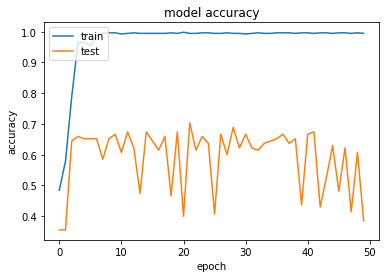

In [74]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

In [77]:
from keras.layers.convolutional import Conv1D, MaxPooling1D
from keras.layers import Flatten, Dropout
from keras.callbacks import EarlyStopping
#Architecture 3
model = Sequential()
model.add(Embedding(vocab_size, EMBEDDING_DIM, input_length=max_length, trainable = False))
model.add(Dropout(0.1))
model.add(Conv1D(filters=256, kernel_size=5, activation='relu'))
model.add(Dropout(0.2))
model.add(MaxPooling1D(pool_size=2))
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

# compile network
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# simple early stopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

# fit the model
history = model.fit(X_train_pad, y_train, batch_size=32, epochs=50, validation_data=(X_test_pad, y_test), verbose=2)

Train on 539 samples, validate on 135 samples
Epoch 1/50
 - 27s - loss: 0.9747 - acc: 0.4898 - val_loss: 0.7096 - val_acc: 0.4148
Epoch 2/50
 - 25s - loss: 0.5821 - acc: 0.6920 - val_loss: 0.6983 - val_acc: 0.4296
Epoch 3/50
 - 25s - loss: 0.4608 - acc: 0.9443 - val_loss: 0.6356 - val_acc: 0.6519
Epoch 4/50
 - 28s - loss: 0.3049 - acc: 0.9703 - val_loss: 0.6769 - val_acc: 0.4889
Epoch 5/50
 - 27s - loss: 0.1831 - acc: 0.9870 - val_loss: 0.6159 - val_acc: 0.6741
Epoch 6/50
 - 26s - loss: 0.1130 - acc: 0.9870 - val_loss: 0.6140 - val_acc: 0.6593
Epoch 7/50
 - 25s - loss: 0.0693 - acc: 0.9907 - val_loss: 0.6348 - val_acc: 0.6222
Epoch 8/50
 - 25s - loss: 0.0534 - acc: 0.9926 - val_loss: 0.6655 - val_acc: 0.5259
Epoch 9/50
 - 25s - loss: 0.0340 - acc: 0.9981 - val_loss: 0.6134 - val_acc: 0.6667
Epoch 10/50
 - 26s - loss: 0.0318 - acc: 0.9963 - val_loss: 0.6765 - val_acc: 0.5704
Epoch 11/50
 - 26s - loss: 0.0276 - acc: 0.9944 - val_loss: 0.7782 - val_acc: 0.4815
Epoch 12/50
 - 27s - loss: 0

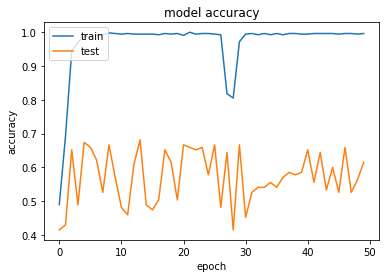

In [78]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Word2Vec Model

In [9]:
import string
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

review_lines = list()
lines = all_company['liststring'].values.tolist()

for line in lines:   
    tokens = word_tokenize(line)
    # convert to lower case
    tokens = [w.lower() for w in tokens]
    # remove punctuation from each word    
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    # remove remaining tokens that are not alphabetic
    words = [word for word in stripped if word.isalpha()]
    # filter out stop words    
    stop_words = set(stopwords.words('english'))
    words = [w for w in words if not w in stop_words]
    review_lines.append(words)

In [10]:
len(review_lines)

543

In [12]:
import gensim 

EMBEDDING_DIM = 100
# train word2vec model
model = gensim.models.Word2Vec(sentences=review_lines, size=EMBEDDING_DIM, window=5, workers=4, min_count=1)
# vocab size
words = list(model.wv.vocab)
print('Vocabulary size: %d' % len(words))

Vocabulary size: 68128


In [13]:
# save model in ASCII (word2vec) format
filename = 'nyt_embedding_word2vec.txt'
model.wv.save_word2vec_format(filename, binary=False)

/usr/local/lib/python3.6/site-packages/smart_open/smart_open_lib.py:398: UserWarning: This function is deprecated, use smart_open.open instead. See the migration notes for details: https://github.com/RaRe-Technologies/smart_open/blob/master/README.rst#migrating-to-the-new-open-function
  'See the migration notes for details: %s' % _MIGRATION_NOTES_URL


In [14]:
model.wv.most_similar('job')#, topn =1)

[('although', 0.7747249603271484),
 ('done', 0.7618248462677002),
 ('task', 0.752723217010498),
 ('added', 0.7519810199737549),
 ('figure', 0.7475916147232056),
 ('needed', 0.7335801720619202),
 ('idea', 0.7313542366027832),
 ('work', 0.7293825149536133),
 ('success', 0.7269136905670166),
 ('really', 0.7243425846099854)]

In [18]:
model.wv.most_similar('history')#, topn =1)

[('devoted', 0.7465667724609375),
 ('english', 0.7300233840942383),
 ('art', 0.7210599184036255),
 ('trounced', 0.7112534642219543),
 ('museums', 0.7071324586868286),
 ('unreason', 0.7064419984817505),
 ('african', 0.7013242244720459),
 ('mass', 0.7007205486297607),
 ('heritage', 0.6940369606018066),
 ('novelists', 0.6925702095031738)]

In [21]:
import os
import numpy as np
embeddings_index = {}
f = open(os.path.join('', 'nyt_embedding_word2vec.txt'),  encoding = "utf-8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:])
    embeddings_index[word] = coefs
f.close()

In [28]:
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

max_length = 5000
VALIDATION_SPLIT = 0.2

# vectorize the text samples into a 2D integer tensor
tokenizer_obj = Tokenizer()
tokenizer_obj.fit_on_texts(review_lines)
sequences = tokenizer_obj.texts_to_sequences(review_lines)

# pad sequences
word_index = tokenizer_obj.word_index
print('Found %s unique tokens.' % len(word_index))

review_pad = pad_sequences(sequences, maxlen=max_length)
sentiment =  all_company['delta'].values
print('Shape of review tensor:', review_pad.shape)
print('Shape of sentiment tensor:', sentiment.shape)

# split the data into a training set and a validation set
indices = np.arange(review_pad.shape[0])
np.random.shuffle(indices)
review_pad = review_pad[indices]
sentiment = sentiment[indices]
num_validation_samples = int(VALIDATION_SPLIT * review_pad.shape[0])

X_train_pad = review_pad[:-num_validation_samples]
y_train = sentiment[:-num_validation_samples]
X_test_pad = review_pad[-num_validation_samples:]
y_test = sentiment[-num_validation_samples:]

Found 68128 unique tokens.
Shape of review tensor: (543, 5000)
Shape of sentiment tensor: (543,)


In [30]:
EMBEDDING_DIM =100
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))

for word, i in word_index.items():
    if i > num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

In [31]:
print(num_words)

68129


In [34]:
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, GRU
from keras.layers.embeddings import Embedding
from keras.initializers import Constant

# define model
model = Sequential()
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=max_length,
                            trainable=False)
model.add(embedding_layer)
model.add(GRU(units=32,  dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [35]:
model.fit(X_train_pad, y_train, batch_size=128, epochs=25, validation_data=(X_test_pad, y_test), verbose=2)

Train on 435 samples, validate on 108 samples
Epoch 1/25
 - 21s - loss: 0.5141 - acc: 0.0000e+00 - val_loss: 1.0873 - val_acc: 0.0000e+00
Epoch 2/25


KeyboardInterrupt: 